In [1]:
import os
import numpy as np
import pandas
import os
import skimage
from scipy import ndimage, signal
from skimage import exposure
import matplotlib.pyplot as plt
import glob
from skimage import io
import scipy
from scipy import signal
from skimage import feature
from tqdm import tqdm_notebook as tqdm
import json
from matplotlib_scalebar.scalebar import ScaleBar
import networkx as nx
import timeit

In [2]:
def default(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError

In [3]:
def _makeSpheroidClass(path, zRatio, rNoyau, dCells):
    
    for spheroidFolder in tqdm(os.listdir(path)):
        
        spheroidPath = path + '/' + spheroidFolder
        
        if os.path.isdir(spheroidPath):
            
            for timeFolder in os.listdir(spheroidPath):
            
                timePath = spheroidPath + r'\\' + timeFolder
                
                if (timeFolder == '5') & (spheroidFolder== '19'):
                
                    if os.path.isdir(timePath):

                        print('prep image: ' + spheroidFolder + ' folder and time ' + timeFolder)

                        Sph = spheroid(timePath, spheroidFolder, timeFolder, zRatio, rNoyau, dCells)

                        try:

                            Sph._loadImageNuclei(1)
                            Sph._loadImageDead(0)

                            print('image made, starting nuclei ID')

                            Sph._getNuclei()

                            print('nuclei gotten, make spheroid')

                            Sph._makeSpheroid()

                            Sph._initializeDead()

                            with open(path + '\spheroid_' + spheroidFolder + r'_' +  timeFolder + '.json', 'w') as fp:

                                json.dump(Sph.Spheroid, fp, default = default)

                            Sph._verifySegmentation()
                        
                        except: print('Error on: '+ spheroidFolder + ' folder and time ' + timeFolder)

In [4]:
def _makeSingleSpheroidClass(path, zRatio, rNoyau, dCells):
    
    spheroidFolder = '00'
    timeFolder = '00'

    print('prep image: ' + spheroidFolder + ' folder and time ' + timeFolder)

    Sph = spheroid(path, spheroidFolder, timeFolder, zRatio, rNoyau, dCells)
    
    Sph._loadImageNuclei(1)
    Sph._loadImageDead(0)

    print('image made, starting nuclei ID')

    Sph._getNuclei()

    print('nuclei gotten, make spheroid')

    Sph._makeSpheroid()

    Sph._initializeDead()

    with open(path + '\spheroid_' + spheroidFolder + r'_' +  timeFolder + '.json', 'w') as fp:

        json.dump(Sph.Spheroid, fp, default = default)

    Sph._verifySegmentation()

In [5]:
def _sortFiles(path):
    
    for fileName in tqdm(os.listdir(path)):
        
        if not os.path.isdir(path + r'\\' + fileName):
            
            _, position = fileName.split('xy')
            position, _ = position.split('z')
            
            time = '00'

            if not os.path.exists(path + r'\\' + position):
                os.mkdir(path + r'\\' + position)

            if not os.path.exists(path + r'\\' + position + r'\\' + time):
                os.mkdir(path + r'\\' + position + r'\\' + time)

            os.rename(path + r'\\' + fileName, path + r'\\' + position + r'\\' + time + r'\\' + fileName)

    return print('job done')

In [6]:
class spheroid:
    
    """ Spheroid class containing the necessary info to build the spheroid.
    
    ====== NOTICE ======
    
     - All variables starting with a capital letter refer to class variables.
     - All variables starting with '_' refer to a dict
    
    
    ====== PARAMETERS ======
    
    path: string object, path to the folder storing images
    position: string object, well ID
    time: string object, time of experiment"""
    
    def __init__(self, path, position, time, zRatio, rNoyau, dCells):
        
        self.Path = path
        self.Position = position
        self.Time = time
        self.ZRatio = zRatio
        self.RNoyau = rNoyau
        self.DCells = dCells
        self.NucImage = []
        self.DeadImage = []
        self.Thresh = 200
        self.ThreshCell = 200
        self.Percentile = 20
        
    def _loadSpheroid(self, spheroidDict):
        
        self.spheroid = spheroidDict
        
    
    def _loadImageNuclei(self, channelNuc):
        
        image_list = []    
        for filename in sorted(os.listdir(self.Path)): #assuming tif
            
            if '.tif' in filename:
                        
                im = io.imread(self.Path + '/' + filename)
                image_list.append(im[channelNuc])
        
        self.NucImage = np.reshape(image_list, (len(image_list), np.shape(image_list[0])[0], np.shape(image_list[0])[1]))[:, 300:-300, 300:-300]

    def _loadImageDead(self, channelDead):
        
        image_list = []    
        for filename in sorted(os.listdir(self.Path)): #assuming tif
            
            if '.tif' in filename:
                        
                im = io.imread(self.Path + '/' + filename)
                image_list.append(im[channelDead])
        
        self.DeadImage = np.reshape(image_list, (len(image_list), np.shape(image_list[0])[0], np.shape(image_list[0])[1]))[:, 300:-300, 300:-300]
    
    def _getNuclei(self):
        
        if not len(self.NucImage):
            
            ### Check that image to study does exist
            
            print('Image doesnt exist')
        
        self._getMaximaFrame(self._getMaskImage(), self.ZRatio, self.RNoyau)
        #self._duplicataClean()
        
    
    def _makeSpheroid(self):
        
        ### COPYPASTE ABOVE
        
        if not len(self.NucFrame):
            
            ### Check that image to study does exist
            
            print('Image doesnt exist')
                
        """Generates the spheroid dict containing all the essential information about the spheroid.

        ====== PARAMETERS ======

        df: DataFrame containing all the positional information of the cells
        dCells: maximum distance for two cells to be considered as neighbours
        zRatio: pixel ratio between z and xy dimensions
        Image: original, multichannel, 3D image
        state: True/False variable stating if we seek the dead-alive information

        ====== RETURNS ======

        _Spheroid: dict object"""
    
        _Spheroid = {}
    
        _Spheroid['spheroid position'] = self.Position
        _Spheroid['time'] = self.Time
        _Spheroid['cells'] = self._generateCells()
            
        self.Spheroid = _Spheroid
        
        
    def _initializeDead(self):
            
        X = np.arange(0, 40)
        Y = np.arange(0, 40)
        Z = np.arange(0, 40)
        X, Y, Z = np.meshgrid(X, Y, Z)

        mask = np.sqrt((X-20)**2 + (Y-20)**2 + (Z-20)**2/self.ZRatio**2) < self.RNoyau
        mask = np.transpose(mask, (2,1,0)).astype(np.int)
        
        deadConv = scipy.signal.fftconvolve(self.DeadImage, mask, mode='same')

        
        for cellLabel in self.Spheroid['cells'].keys():
            
            x = self.Spheroid['cells'][cellLabel]['x']
            y = self.Spheroid['cells'][cellLabel]['y']
            z = self.Spheroid['cells'][cellLabel]['z']
            
            zlen, _, _ = np.nonzero(mask)
            
            # Test dimension order to verify coherence
            if deadConv[z,x,y]/len(zlen) > self.Thresh:
                
                print('Dead cell')
                
                self.Spheroid['cells'][cellLabel]['state'] = 'Dead'
    
    def _verifySegmentation(self):
        
        if not len(self.NucFrame):
            return print('Image doesnt exist')
        
        if not os.path.exists(self.Path + r'/filmstack/'):
            os.mkdir(self.Path + r'/filmstack/')
        
        zshape, _, _ = np.shape(self.NucImage)
        
        ImageAll = self.NucImage
                
        for n in range(zshape):
                        
            Image = ImageAll[n,:,:]
            
            plt.figure(figsize=(12, 12))
            plt.subplot(111)
            plt.imshow(Image, vmin=0, vmax=1300, cmap=plt.cm.gray)
            plt.axis('off')
            
            scalebar = ScaleBar(0.0000006, location = 'lower right') # 1 pixel = 0.6 umeter
            plt.gca().add_artist(scalebar)
            
            r = self.RNoyau
                        
            for cellLabel in self.Spheroid['cells'].keys():
                
                x = self.Spheroid['cells'][cellLabel]['x']
                y = self.Spheroid['cells'][cellLabel]['y']
                z = self.Spheroid['cells'][cellLabel]['z']
                
                if (r**2 - (z -n)**2/self.ZRatio**2) > 0:
                    
                    rloc = np.sqrt(r**2 - (z -n)**2/self.ZRatio**2)
                    s = np.linspace(0, 2*np.pi, 100)
                    x = rloc*np.sin(s) + x
                    y = rloc*np.cos(s) + y
                    
                    if self.Spheroid['cells'][cellLabel]['state'] == 'Dead':

                        plt.plot(y, x, 'r-')
                        
                    else: plt.plot(y, x, 'b-')
            
            plt.savefig(self.Path + r'/filmstack/im_' + str(n) +'.png')
            plt.close()
        
    #### UTILITY FUNCTIONS ####
    
    # Question: how store utility functions in Python class?
    
    def _getMaskImage(self):

        blurred = ndimage.gaussian_filter(self.NucImage, sigma=2)
        mask = (blurred > np.percentile(blurred, 93)).astype(np.float)
        mask += 0.1

        binary_img = mask > 0.5
        binary_img = skimage.morphology.binary_closing(ndimage.binary_dilation(ndimage.binary_erosion(binary_img)).astype(np.int))

        return np.multiply(blurred, binary_img)
    
    def _getMaximaFrame(self, Image, zRatio, rNoyau):

        """Generates the spheroid dict containing all the essential information about the spheroid.

        ====== PARAMETERS ======

        Image: original, multichannel, 3D image
        zRatio: pixel ratio between z and xy dimensions
        rNoyau: radius of the prior (i.e. expected radius of the nuclei)

        ====== RETURNS ======

        _Spheroid: dict object"""

        z, x, y = np.nonzero(Image)
        binary_img = Image > 0 # Regarder si le seuil est le bon ou pas

        mask_image_crop = Image[min(z):max(z), min(x):max(x), min(y):max(y)]

        # Making of the convolution mask
        
        X = np.arange(0, 40)
        Y = np.arange(0, 40)
        Z = np.arange(0, 40)
        X, Y, Z = np.meshgrid(X, Y, Z)

        mask = np.sqrt((X-20)**2 + (Y-20)**2 + (Z-20)**2/zRatio**2) < rNoyau
        mask = np.transpose(mask, (2,1,0))
        zlen, _, _ = np.nonzero(mask)
        
        start = timeit.default_timer()
        
        # We divide by len(zlen) so has to have the average value over the mask

        conv = scipy.signal.fftconvolve(ndimage.gaussian_filter(self.NucImage, sigma=1), mask/len(zlen), mode='same')

        mask_conv = ndimage.gaussian_filter(np.multiply(conv, binary_img), sigma=1)
        
        stop = timeit.default_timer()
        
        print('Convolution Time: ', stop - start)  
        
        # Distance minimum entre deux noyaux repérés par l'algorithme de convolution
        # On prend exprès 10% de marge supplémentaire pour éviter les contacts inopportuns.
        # On fait aussi attention au liveau minimal d'intensite des pics.
        
        #r = int(self.RNoyau/4)
        r = 3
        
        start = timeit.default_timer()
        
        coordinates = np.asarray(skimage.feature.peak_local_max(mask_conv, min_distance = r, threshold_abs = self.ThreshCell))
        
        stop = timeit.default_timer()
        
        print('Corrdinates ID Time: ', stop - start)
        print(str(len(coordinates)) + ' cells ID')

        #coordinates[:, 0] += min(z)
        #coordinates[:, 1] += min(x)
        #coordinates[:, 2] += min(y)
        
        a, b = np.shape(coordinates)

        coordinates = np.hstack((coordinates, np.asarray([np.arange(a)]).T))

        df = pandas.DataFrame(coordinates, columns = ['z', 'x', 'y', 'label'])
        
        start = timeit.default_timer()

        #for ind, row in df.iterrows():
        #    df.loc[ind, 'val'] = mask_conv[int(row['z']) - min(z), int(row['x']) - min(x), int(row['y']) - min(y)]
        #    df.loc[ind, 'label'] = int(ind)
        #    
        #stop = timeit.default_timer()
        
        #print('Frame creation time: ', stop - start)

        self.NucFrame = df
        
    
    def _duplicataClean(self):
        
        df = self.NucFrame

        for ind, row in df.iterrows():

            lf = df.loc[(df['x'] - row['x'])**2 + (df['y'] - row['y'])**2 < 4] # on élimine les duplicatats selon z

            if len(lf) > 1:

                a = len(df)
                df = df.drop(lf.loc[lf['val'] < lf['val'].max()].index)

        self.NucFrame = df
        
    def _generateCells(self):

        """ This function serves to generate the cells and gives back a dic object.

        ====== PARAMETERS ======

        df: DataFrame containing the relevant positional information
        dCells: minimum distance between any two cells
        zRatio: ratio between the xy and z dimensions

        ====== RETURNS ======

        _Cells: dict object"""

        _Cells = {}
        
        df = self.NucFrame
        dCells = self.DCells
        zRatio = self.ZRatio

        df['label'] = df['label'].astype(int).astype(str)

        for label in df['label'].unique():

            dic = {}

            dic['x'] = df.loc[df['label'] == label, 'x'].iloc[0]
            dic['y'] = df.loc[df['label'] == label, 'y'].iloc[0]
            dic['z'] = df.loc[df['label'] == label, 'z'].iloc[0]
            dic['neighbours'] = self._nearestNeighbour(df, label, dCells, zRatio)
            dic['state'] = 'Live'

            _Cells[str(int(label))] = dic

        return _Cells

    def _nearestNeighbour(self, df, label, dCells, zRatio):
    
        """Returns a list of float labels of the cells closest to the given label.
        This method is dependant only on a minimum distance given by the investigator."""

        x = df.loc[df['label'] == label, 'x'].iloc[0]
        y = df.loc[df['label'] == label, 'y'].iloc[0]
        z = df.loc[df['label'] == label, 'z'].iloc[0]

        lf = df.loc[df['label'] != label].copy() 

        return lf.loc[np.sqrt((lf['x'] - x)**2 + (lf['y'] - y)**2 + (lf['z'] - z)**2/zRatio**2) < dCells, 'label'].values.tolist()


In [ ]:
### PAY ATTENTION TO THE CHANNEL ORDER

path = r'X:\Gustave\Experiments\Nuclei Segmentation\01072019\tif\2\00'

_makeSingleSpheroidClass(path, 1/4, 10, 70)

We use the refined metrics of networkx to add centrality, degree and other measures to the death/survival rates of the spheroid. The following process follows:

 - open json file
 - modify the spheroid properties
 - save global properties in soheroid file
 - save file

In [7]:
def _refineSph(dic):
    
    G = _makeG(dic)
    
    A = networkx.betweenness_centrality(G) # betweeness centrality
    B = networkx.clustering(G)
    C = networkx.degree(G)
    
    for v in G:
        
        dic['cells'][v]['degree'] = C[v]
        dic['cells'][v]['clustering'] = B[v]
        dic['cells'][v]['centrality'] = A[v]
        
    dic['N'] = len(dic['cells'])
    dic['assortativity'] = nx.degree_assortativity_coefficient(G)
    dic['average degree'] = np.asarray([float(C[v]) for v in G]).mean()
    
    return dic

In [ ]:
_refineSph(_Sph)

In [8]:
def _getLen(dic):
    
    return len(dic['cells'].keys())

In [9]:
def _getProperties(dic):
    
    G=nx.Graph()
    
    G.add_nodes_from(dic.keys())
        
    _Cells = dic['cells']
    
    for key in _Cells.keys():
    
        neighbours = _Cells[key]['neighbours']
    
        for node in neighbours:
    
            G.add_edge(key, node)
        
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    

    return nx.density(G), degree_sequence

In [10]:
def _getAllGraphs(path):
    
    df = pandas.DataFrame()
    i = 0
    
    degree = []
    
    for dicName in glob.glob(path + r'/' + '*.json'):
                
        with open(dicName, "r") as read_file:
            data = json.load(read_file)
                
        _, sphNum = dicName.split('spheroid_')
        sphNum, _ = sphNum.split('.')
        
        density, deg = _getProperties(data)
        
        degree += deg
        
        df.loc[i, 'label'] = sphNum
        df.loc[i, 'density'] = density
        i += 1
        
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree)
    deg, cnt = zip(*degreeCount.items())
        
    return df, deg, cnt

## Image Sorting

In [ ]:
_sortFiles(r'X:\Gustave\Experiments\Nuclei Segmentation\28062019\scanSeb')

## Graph analysis

In [13]:
def _makeG(dic):
    
    G=nx.Graph()
    _Cells = _Sph['cells']
    G.add_nodes_from(_Cells.keys())
    
    for key in _Cells.keys():
    
        neighbours = _Cells[key]['neighbours']
    
        for node in neighbours:
    
            G.add_edge(key, node)
        
    return G

In [25]:
path = r'X:\Gustave\Experiments\Nuclei Segmentation\28062019\scanSeb\01\00'
dicName = glob.glob(path + r'/' + '*.json')[0]

with open(dicName, "r") as read_file:
    _Sph = json.load(read_file)

In [26]:
G = _makeG(_Sph)

In [ ]:
import networkx

In [ ]:
nx.degree_assortativity_coefficient(G)

In [27]:
from community import community_louvain

partition = community_louvain.best_partition(G)

In [28]:
C = partition

In [32]:
import networkx
A = networkx.betweenness_centrality(G)

In [35]:
B = networkx.clustering(G)

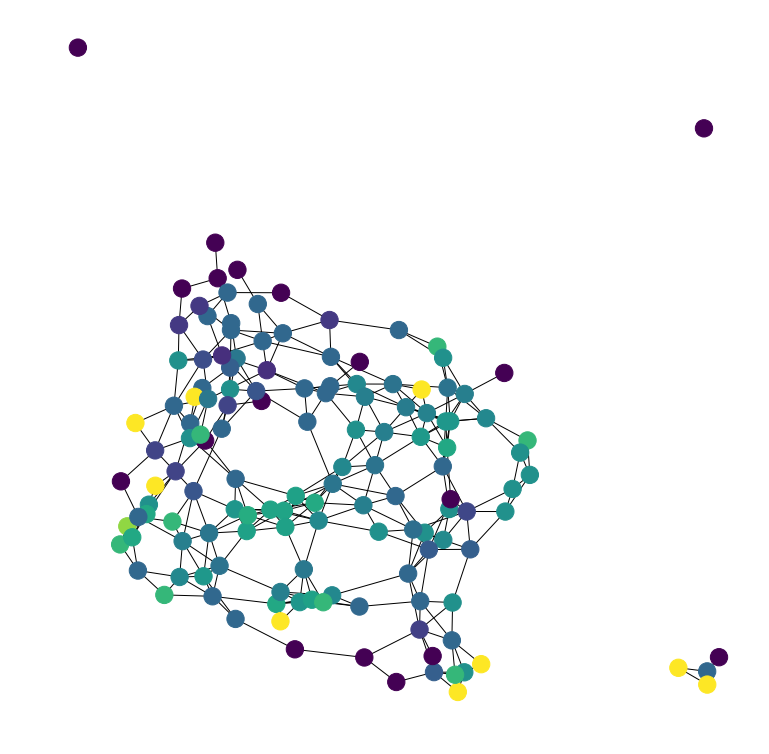

In [37]:
import re
import sys

import matplotlib.pyplot as plt
import networkx as nx

# draw with matplotlib/pylab
plt.figure(figsize=(10,10))

# with nodes colored by degree sized by population
node_color = [float(B[v]) for v in G]

nx.draw_spring(G, node_color=node_color,
        with_labels=False)

plt.show()

In [38]:
import collections

In [39]:
df, deg, cnt = _getAllGraphs(r'X:\Gustave\Experiments\Nuclei Segmentation\01072019\tif')

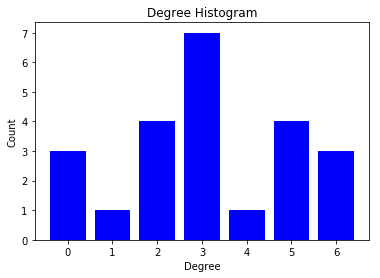

In [40]:
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticklabels(deg)
ax.set_xticks([d + 0 for d in deg])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/math.factorial(k))*np.exp(-lamb)

l = np.dot(np.asarray(list(deg)),np.asarray(list(cnt)))/np.sum(np.asarray(list(cnt)))

plt.plot(deg, poisson(np.asarray(list(deg)), l), 'r-', lw=2)
plt.show()

In [ ]:
df

In [ ]:
%matplotlib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# What follows is a copy of the 3D plot example code.
# Data is randomly generated so there is no external data import.

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x'], df['y'], df['z'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim(0,51)

plt.show()


from matplotlib_scalebar.scalebar import ScaleBar

for n in range(len(mask_img)):

    plt.subplot(111)
    plt.imshow(mask_img[n], cmap=plt.cm.gray, alpha = 0.8)
    plt.axis('off')
    
    scalebar = ScaleBar(0.000001, location = 'lower right') # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)

    lf = df.loc[df['z'] == n]
    mf = df.loc[df['z'] == n-1]
    pf = df.loc[df['z'] == n+1]

    plt.plot(mf['y'], mf['x'], 'go', label = 'z = ' + str(n-1))
    plt.plot(lf['y'], lf['x'], 'yo', label = 'z = ' + str(n))
    plt.plot(pf['y'], pf['x'], 'ro', label = 'z = ' + str(n+1))

    plt.show()
    plt.legend()
    
    #plt.savefig(r'/Users/gustaveronteix/Desktop/Image Stack/filmstack/im_' + str(n) +'.png')
    plt.close()

In [ ]:
path = r'X:\Gustave\Experiments\Nuclei Segmentation\01072019\tif\\'
dicName = path + '\spheroid_00_00.json'

with open(dicName, "r") as read_file:
    _Sph = json.load(read_file)

import networkx as nx
G=nx.Graph()
_Cells = _Sph['cells']
G.add_nodes_from(_Cells.keys())
for key in _Cells.keys():
    
    neighbours = _Cells[key]['neighbours']
    
    for node in neighbours:
    
        G.add_edge(key, node)

centrality = []
eV = nx.degree_centrality(G)

import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

for key in _Cells.keys():
        
    centrality.append(eV[key])

plt.figure(figsize=(8, 8))

pos = nx.spring_layout(G)
im = nx.draw_networkx_nodes(G, pos, node_size=20, node_color = centrality, cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, alpha=0.4)

#legend
cbar = plt.colorbar(im)
cbar.set_label('Eigenvector centrality', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

plt.axis('off')
#plt.savefig(path + '\\fig_58_5.png')
plt.show()


In [59]:
import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def generate_random_3Dgraph(_Cells, zRatio, dCells, scale, seed=None):
    
    # Generate a dict of positions
    pos = {int(i): (scale*_Cells[i]['x'], scale*_Cells[i]['y'], scale*_Cells[i]['z']/zRatio) for i in _Cells.keys()}
    
    # Create random 3D network
    G = nx.random_geometric_graph(len(_Cells), dCells, pos=pos)
 
    return G

def network_plot_3D(G, angle, save=False):
 
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Get number of nodes
    n = G.number_of_nodes()
 
    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])
 
    # Define color range proportional to number of edges adjacent to a single node
    colors = [G.degree(i) for i in range(n)]
    cm = plt.cm.plasma
 
    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,8))
        ax = Axes3D(fig)
        

        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        
        for i,j in enumerate(G.edges()):
 
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
        # Plot the connecting lines
            ax.plot(x, y, z, c='black', alpha=0.2)
            
        x = []
        y = []
        z = []
        nodeColor = []
        s = []
            
        for key, value in pos.items():
            x.append(value[0])
            y.append(value[1])
            z.append(value[2])
            nodeColor.append(colors[key])
            s.append(20+20*G.degree(key))
            
        # Scatter plot
        sc = ax.scatter(x, y, z, c=nodeColor, cmap=cm, s=s, edgecolors='k', alpha=0.7)
        
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted

    
    # Set the initial view
    ax.view_init(30, angle)
    fig.patch.set_facecolor((1.0, 1, 1))
    ax.set_facecolor((1.0, 1, 1))
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    plt.rc('grid', linestyle="-", color='black')
    
    ax.set_xlabel('X axis ($\mu m$)')
    ax.set_ylabel('Y axis ($\mu m$)')
    ax.set_zlabel('Z axis ($\mu m$)')
    ax.set_xlim(100, 250)
    ax.set_ylim(100, 250)
    #ax.set_zlim(50, 90)

 
    # Hide the axes
    #ax.set_axis_off()
    
    #legend
    axins = inset_axes(ax,
                   width="2%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='upper right',
                    bbox_to_anchor=(0., 0., 0.95, 0.8),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    cbar = fig.colorbar(sc, cax=axins)
    cbar.set_label('Node degree', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    
    return

In [60]:
#dicName = path + '\spheroid_00_00.json'

#with open(dicName, "r") as read_file:
#    _Sph = json.load(read_file)

import networkx as nx
G=nx.Graph()
_Cells = _Sph['cells']

In [61]:
G = generate_random_3Dgraph(_Cells, 1/5, 23, scale = 1/3, seed=None)

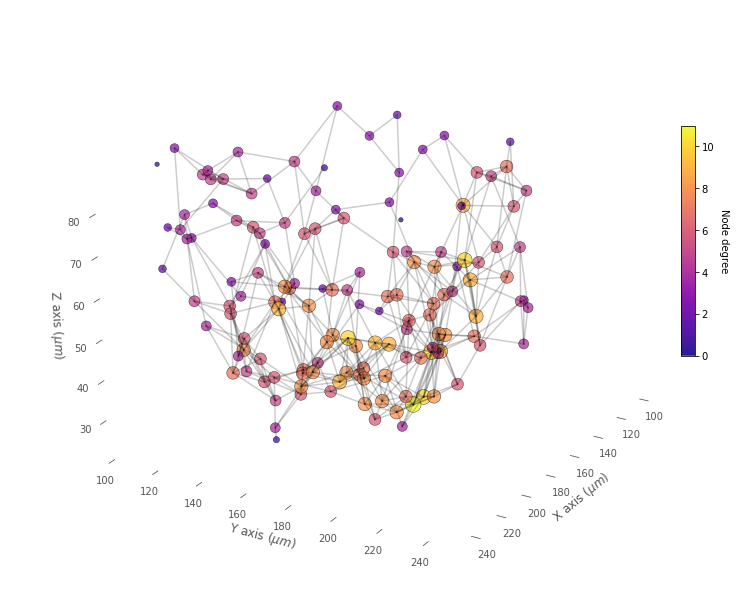

In [62]:
network_plot_3D(G,30, save=False)

plt.savefig(path + '\\3D_00_00.png')
plt.show()